In [1]:
import os
import cooler
import numpy as np
import pandas as pd
from scipy.stats import norm, zscore

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

from itertools import cycle, islice
import xarray as xr
from glob import glob
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import ndimage as nd
from tqdm import tqdm


mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#mpl.rcParams['font.family'] = 'sans-serif'
#mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [2]:
ct = 'Oligo_NN'

In [3]:
chrom_size_path = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:-1]

In [4]:
leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
leg

['Oligo_NN.8wk', 'Oligo_NN.9mo', 'Oligo_NN.18mo']

In [5]:
indir = '/data/female-amb/loop/'
ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
ldir = f'/data/female-amb/Diff.Result/loop_ct_age/diff/{ct}'
cdir = f'/home/qzeng_salk_edu/project/240204-redo-compartment/Call.DiffComp.CellType.Age/{ct}'

In [6]:
chrom_size_path = f'/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)

In [7]:
genemeta = pd.read_csv('/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz', sep = '\t', index_col = 'gene_name')
genemeta = genemeta[~genemeta.index.duplicated(keep='first')]
genemeta.head()

,chrom,source,feature,start,end,score,strand,phase,gene_id,transcript_id,...,gene_status,transcript_type,transcript_status,transcript_name,exon_number,exon_id,level,mgi_id,havana_gene,tag
gene_name,,,,,,,,,,,,,,,,,,,,,
4933401J01Rik,chr1,HAVANA,gene,3073253,3074322,.,+,.,ENSMUSG00000102693.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:1918292,OTTMUSG00000049935.1,NaN
Gm26206,chr1,ENSEMBL,gene,3102016,3102125,.,+,.,ENSMUSG00000064842.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,MGI:5455983,NaN,NaN
Xkr4,chr1,HAVANA,gene,3205901,3671498,.,-,.,ENSMUSG00000051951.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:3528744,OTTMUSG00000026353.2,NaN
Gm18956,chr1,HAVANA,gene,3252757,3253236,.,+,.,ENSMUSG00000102851.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,MGI:5011141,OTTMUSG00000049958.1,pseudo_consens
Gm37180,chr1,HAVANA,gene,3365731,3368549,.,-,.,ENSMUSG00000103377.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:5610408,OTTMUSG00000049960.1,NaN


In [8]:
## Load boundary probability
bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]
bound_prob_ct

,chr1_0,chr1_1,chr1_2,chr1_3,chr1_4,chr1_5,chr1_6,chr1_7,chr1_8,chr1_9,...,chr19_2448,chr19_2449,chr19_2450,chr19_2451,chr19_2452,chr19_2453,chr19_2454,chr19_2455,chr19_2456,chr19_2457
Oligo_NN.8wk,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005988,0.053037,0.005988,0.001711,0.002994,0.003849,0.0,0.0,0.0,1.0
Oligo_NN.9mo,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005133,0.050898,0.007271,0.002566,0.004277,0.004277,0.0,0.0,0.0,1.0
Oligo_NN.18mo,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002566,0.061591,0.007271,0.002994,0.001711,0.001283,0.0,0.0,0.0,1.0


In [9]:
## Load insulation score
ins_count = xr.open_dataset(f'/home/qzeng_salk_edu/project/240205-domain/hicluster_bulk_domain/{ct}.insulation.nc')
ins_count = ins_count.sel({'bin': (ins_count['bin_chrom']!='chrX')})
ins_count['ratio'] = (ins_count.sel({'type':'inter'})['__xarray_dataarray_variable__'] / ins_count.sel({'type':'intra'}))['__xarray_dataarray_variable__']
ins = ins_count['ratio'].to_pandas().loc[leg]

In [10]:
##select all age diff domain
binall = pd.read_hdf(f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}/{ct}_bin_stats.hdf', key='data')
selb = (binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'])
selected_bins = selb[selb].index
len(selected_bins)

18

## change function

In [11]:
gene = 'Il33'

In [12]:
ins.columns = binall.index

In [13]:
info_df = genemeta.loc[gene]
slop = 2000
chrom, diff_domain_l, diff_domain_r = info_df['chrom'],info_df['start']-slop, info_df['end'] + slop

In [14]:
# _bin = 'chr7_4626'
# info_df = binall.loc[_bin] 
# chrom, diff_domain_l, diff_domain_r = info_df['chrom'],info_df['start'], info_df['end']

In [15]:
lslop, rslop = 1000000, 1000000
ll, rr = (diff_domain_r - lslop), (diff_domain_l + rslop)
print(f"{chrom}:{diff_domain_l}-{diff_domain_r}")

chr19:29923114-29962718


In [16]:
print(f"{chrom}:{ll}-{rr}")

chr19:28962718-30923114


In [17]:
resl = 10000
loopl, loopr = (ll//resl), (rr//resl)
print(loopl, loopr)

2896 3092


In [18]:
## select differential loop
loopall = pd.read_hdf(f'{ldir}/merged_loop.hdf', key='data')
sell = ((loopall[0]==chrom) & 
        (zscore(np.log(loopall['Qanova']))>norm.isf(0.15)) & 
        (zscore(np.log(loopall['Tanova']))>norm.isf(0.15)) & 
        (loopall[1]>ll) & (loopall[5]<rr))
print(sell.sum())

28


In [19]:
## select differential boundary
binall = pd.read_hdf(f'{ddir}/{ct}_bin_stats.hdf', key='data')
selb = (binall['chrom']==chrom) & (binall['start']>=ll) & (binall['start']<rr) & binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'] #& binall['bklfilter']
print(selb.sum())

0


In [20]:
## select differential compartment

resc = 100000
comp = pd.read_csv(f'{cdir}/DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph', sep='\t', header=0, index_col=None)
comp.index = comp['chr'] + '_' + (comp['start'] // resc).astype(str)
bincomp = comp[['chr', 'start', 'end', 'sample_maha', 'pval', 'padj']]
comp = comp.iloc[:,3:6]
comp.columns = leg
#selc = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr) & (zscore(bincomp['sample_maha'])>norm.isf(0.025))
diff_selc = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr) & (bincomp['padj'] < 0.05)
print(diff_selc.sum())

0


In [21]:
dstall = []
for group in leg:
    cool = cooler.Cooler(f'/data/female-amb/loop/{group}/{group}/{group}.Q.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).tocsr()
    tmp = Q[loopl:loopr, loopl:loopr].toarray()
    dst = nd.rotate(tmp, 45, order=0, reshape=True, prefilter=False, cval=0)
    dstall.append(dst)

/var/tmp/ipykernel_116161/2445633962.py:15: RuntimeWarning: invalid value encountered in divide
  change = np.log2(dstall[2]/dstall[0])


Text(0.5, 0.98, 'chr19:29923114-Il33')

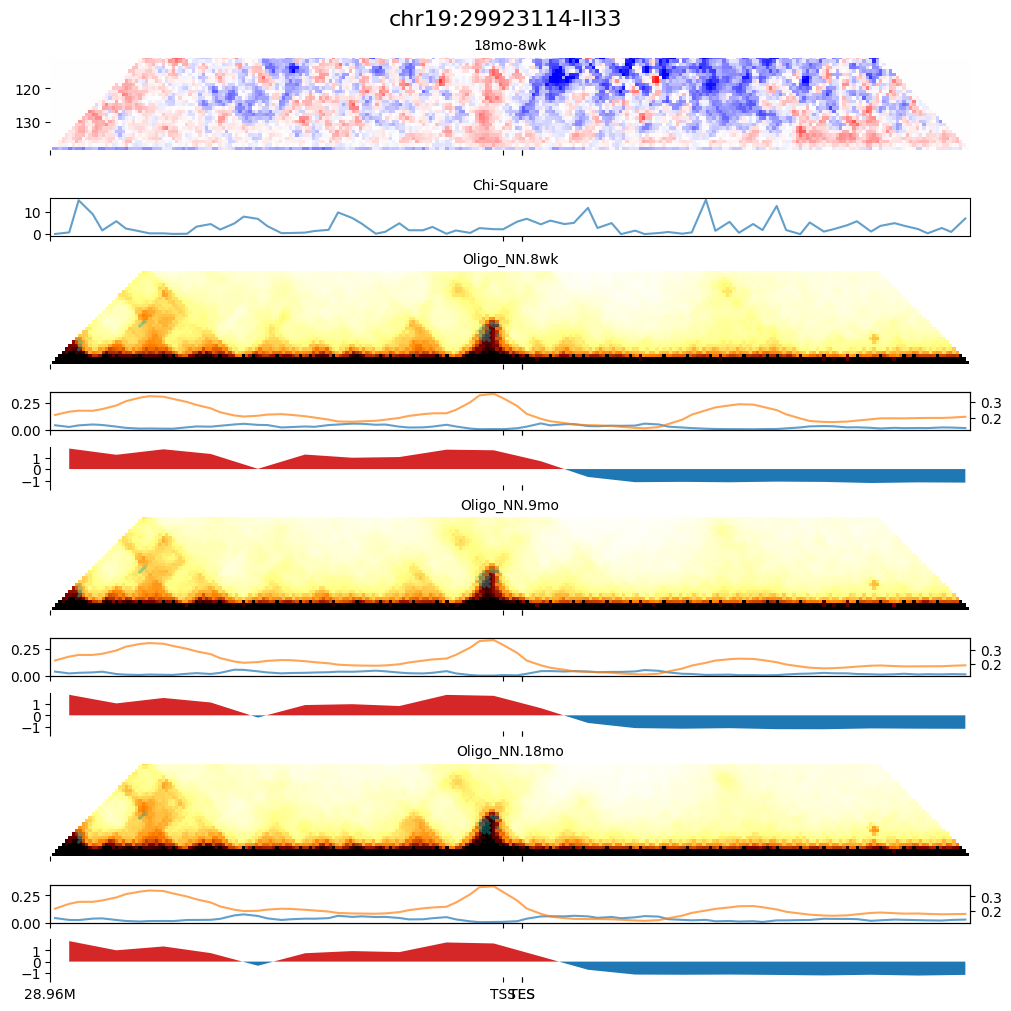

In [24]:
required_repetitions = len(leg)
height_ratios = [3.5]+[1] + np.tile([3.5, 1,1], required_repetitions).tolist()
nrows = len(leg) * 3 + 2

fig, axes = plt.subplots(nrows, 1, figsize=(10,10), 
                         gridspec_kw={'height_ratios': height_ratios}, dpi=100, sharex='all', constrained_layout = True)
legname = leg
tmpd = binall.loc[selb, 'start'] // resl - loopl
tmpl = loopall.loc[sell, [1,4]].values // resl - loopl
tmpc = bincomp.loc[diff_selc, 'start'] // resl - loopl

ax = axes[0]
# change = dstall[2]/dstall[0]
# vmax  = 0.005
change = np.log2(dstall[2]/dstall[0])
change_no_nan = np.nan_to_num(change, nan=0)
value = 1
h = len(change)
ax.set_title('18mo-8wk', fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
img = ax.imshow(change_no_nan, cmap='bwr',vmin=-value, vmax=value) 
ax.set_ylim([0.5*h, 0.4*h])

ax = axes[1] 
sel = (binall['chrom']==chrom) & (binall['start']>=ll) & (binall['start']<rr)
xpos = (binall.loc[sel, 'start'] // resl - loopl) * np.sqrt(2)
ax.plot(xpos, binall.loc[sel, 'chi2_sc'].values, 
        c='C0', alpha=0.7)

ax.set_title('Chi-Square', fontsize=10)
ax.set_xlim([0, (loopr-loopl-1)*np.sqrt(2)])

for i in range(len(leg)):
    vmax  = 0.015
    ax = axes[i*3+2]
    ax.set_title(legname[i], fontsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    img = ax.imshow(dstall[i], cmap='afmhot_r',vmin=0, vmax=vmax) #, 
    h = len(dstall[i])
    ax.set_ylim([0.5*h, 0.4*h])
    ax.set_xlim([0, h])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.scatter((tmpl[:, 0]+tmpl[:, 1])/np.sqrt(2), 0.5*h-(tmpl[:, 1]-tmpl[:, 0])/np.sqrt(2), 
           alpha=0.4, s=2, marker='D', edgecolors='c', color='none')
    
    ax = axes[i*3+3]
    ax.plot(xpos, bound_prob_ct.loc[leg[i], sel].values, c='C0', alpha=0.7)
    ax.scatter(tmpd * np.sqrt(2), np.zeros(len(tmpd))+0.05, color='r', s=4)
    ax.set_ylim([0, 0.35])
    ax2 = ax.twinx()
    x = ( binall.loc[sel, 'start'] // resl - loopl ) * np.sqrt(2)
    ## plot insulation score, use 10k coordinate
    ax2.plot(x, 
             ins.loc[leg[i], sel].values, 
             c='C1', alpha=0.7)
   

    ax = axes[i*3+4]
    sns.despine(bottom=True, ax=ax)
    ## plot compartment, use 10k coordinate
    selc = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr)
    x = ( bincomp.loc[selc, 'start'] // resl - loopl ) * np.sqrt(2)
    y = comp.loc[selc, leg[i]].values
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.scatter(tmpc  * np.sqrt(2), np.zeros(len(tmpc)), color='r', s=4)
    
ax.set_xlim([0, (loopr-loopl-1)*np.sqrt(2)])
ax.set_xticks(np.sqrt(2)*np.array(np.arange(0, loopr-loopl+1, 100).tolist() + [diff_domain_l//resl-loopl, diff_domain_r//resl-loopl]))
ax.set_xticklabels([])
ax.set_xticklabels([f'{(xx+loopl)/100}M' for xx in np.arange(0, loopr-loopl+1, 100)]+['TSS','TES'])
fig.suptitle(f"{chrom}:{diff_domain_l}-{gene}", fontsize=16)
#fig.savefig(f'figure/LTR.pdf', bbox_inches = 'tight')